Notebook to predict endometriosis in 2 steps:
1) Predict presence or absence of endometriosis in general, superficial or profound
2) Among those patients where the model predcited endometriosis, predict the type of endometriosis (superficial or profound)

In [20]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
import seaborn as sns
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

#import eli5

# Utils for NLP :
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree, multilabel_multioutput_svc, multilabel_multioutput_LR, custom_show_weights

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists

[nltk_data] Downloading package stopwords to /home/nounou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-23 16:47:38.864856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 16:47:40.042748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
### Choisir soit les données synthétisées où l'information des données gynéco a été priorisé, soit receuil
# (Priorisé = dans le cas d'un conflit entre gynéco et receuil, on prend soit l'info dans gynéco soit receuil)

data_select = 'gynéco'     # 'gynéco', 'receuil', ou 'original'

recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
if data_select != 'original':
    columns_receuil_to_include = ['Numéro anonymat', 'age', 'imc', 'g', 'p', 'anapath.lusd','anapath.lusg','anapath.torus','anapath.autre']
    recueil_imc = recueil_imc[columns_receuil_to_include]
recueil_imc = recueil_imc.rename(columns={'Numéro anonymat': 'Anonymisation'})
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)

if data_select in ['gynéco', 'receuil']:
    df = pd.read_excel(f'Data/DATA_PROCESSED/data_synth_priorité_{data_select}.xlsx')
else:
    # If original data are used, we don't need the synthesized ones except to note the patients
    df = pd.read_excel(f'Data/DATA_PROCESSED/data_synth_priorité_gynéco.xlsx')

# Note les information originales receuil, en prenant les mêmes patientes
# Explication: On a pas les même sets de patientes entre receuil et gynéco, comme les deux ont été synthétisés, on a perdu des patientes
patients_in_data_synth = list(pd.unique(df['Anonymisation']))
include_patients = 'in_synth'   # 'all' or 'in_synth'
recueil_imc_patients_in_synth = recueil_imc.loc[recueil_imc['Anonymisation'].isin(patients_in_data_synth)]
    
print(f'Number of original patients in receuil: {recueil_imc.shape[0]}')
print(f'Number of patients in synthesized data: {recueil_imc_patients_in_synth.shape[0]}')
if data_select == 'original':
    if include_patients == 'in_synth':
        df = recueil_imc_patients_in_synth.copy()
    else:
        df = recueil_imc.copy()

# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    if col_to_drop in df.columns:
        df = df.drop(col_to_drop, axis=1)

df_orig = df.copy()

Number of original patients in receuil: 181
Number of patients in synthesized data: 176


In [22]:
# Note most important feautres = those that appear in top 10 of feature importances of model
features_important = ['imc', 'age', 'g', 'atcd.endo', 'atcd.endo.type', 'atcd.infertilite', 'atcd.absentéisme', 
                      'irm.adm', 'irm.lusg', 'echo.lusg', 'echo.lusd', 'echo.oma', 'echo.adm', 
                      'rectosonographie_réalisée', 'lésion LUS G à la rectosonographie', 'lésion rectum à la rectosonographie',
                      'échographie_réalisée', 'tv.douleur.lusg', 'tv.douloureux', 'tv.nodule.lusd', 
                      'nausées', 'douleurs_defecations', 'dysuries', 'sf.dig.diarrhée', 'spotting', 'sf.dig.constip', 'désir.G', ]

In [23]:
# Drop all columns with percentage missing values higher than a given threshold
features_select = 'all'  # 'by_perc_missing'
if features_select == 'all':
    thresh_missing = 100
    
    # Calculer le pourcentage de NaN pour chaque colonne
    na_percentage = df.isna().mean() * 100

    # Créer un nouveau DataFrame avec les résultats
    na_df = pd.DataFrame({
        'Column': na_percentage.index,
        'NaN Percentage': na_percentage.values
    })

    # Trier le DataFrame par pourcentage de NaN en ordre décroissant
    na_df_sorted = na_df.sort_values(by='NaN Percentage', ascending=False)
    na_df_filtered = na_df_sorted[na_df_sorted['NaN Percentage'] > 0]

    # Step 1: Sort columns based on NaN percentage in descending order
    sorted_na_columns = na_df_filtered.sort_values(by='NaN Percentage', ascending=False)['Column']
    columns_no_missing = list(na_df_sorted.loc[na_df_sorted['NaN Percentage']==0, 'Column'])
    columns_above_threshold = na_percentage[na_percentage >= thresh_missing].index.tolist()
    columns_to_keep = list(df.drop(columns_above_threshold, axis=1).columns)
    if 'Anonymisation' not in columns_to_keep:
        columns_to_keep = columns_to_keep + ['Anonymisation']
    print(f'{len(columns_to_keep)} columns remaining')

else:
    columns_to_keep = list(df.columns)

90 columns remaining


In [24]:
# Try including different patients, for example filtering out those with many missing values
patients_select = 'by_perc_missing'   #'by_perc_missing'
if patients_select == 'by_perc_missing':
    max_perc_missing = 20
    if features_select == 'by_perc_missing':
        df = df[columns_to_keep]
    # Recompute percentage missing df because features might have been rejected
    df_missing_per_patient = pd.DataFrame()
    df_missing_per_patient['Anonymisation'] = df['Anonymisation']
    df_missing_per_patient['nmissing'] = df.apply(lambda x: x.isna().sum(), axis=1)
    df_missing_per_patient['perc_missing'] = (df_missing_per_patient['nmissing'] / df.shape[0]) * 100
    df_missing_per_patient_sorted_ascending = df_missing_per_patient.sort_values(by='nmissing', ascending=True)
    patients_select = list(df_missing_per_patient_sorted_ascending.loc[df_missing_per_patient_sorted_ascending.perc_missing<=max_perc_missing, 'Anonymisation'])
    df = df.loc[df['Anonymisation'].isin(patients_select)]
    print(f'{len(patients_select)} patients remaining')

131 patients remaining


In [25]:
if data_select != 'original':
    df_with_target = pd.merge(df, recueil_imc, on=['Anonymisation'])
else:
    df_with_target = df.copy()
endometriose_generale = df_with_target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus','anapath.autre']].sum(axis=1).apply(lambda x: Binarisation(x))
df_with_target['endometriose_generale'] = endometriose_generale

df_with_target_endometriosis_patients = df_with_target.loc[df_with_target.endometriose_generale==1]
endometriose_profonde = df_with_target_endometriosis_patients.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
df_with_target_endometriosis_patients['endometriose_profonde'] = endometriose_profonde

df_with_target.head()

/tmp/ipykernel_14335/3334008925.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_target_endometriosis_patients['endometriose_profonde'] = endometriose_profonde


,Anonymisation,atcd.endo,atcd.endo.type,atcd.chir.endo,atcd.infertilite,atcd.fiv,desir.G,atcd.absenteisme,ttt.op,ttt.p,...,traitement_hormonal,age,imc,g,p,anapath.lusd,anapath.lusg,anapath.torus,anapath.autre,endometriose_generale
0,AA-071,0,NaN,0,0,0,0,1.0,0.0,1.0,...,0,35,26.3,5,3,0,1,0,0,1
1,AB-067,1,2.0,0,0,0,0,0.0,1.0,1.0,...,1,31,27.4,4,2,0,0,0,0,0
2,AC-131,1,2.0,1,0,0,0,1.0,1.0,1.0,...,1,27,16.4,0,0,0,0,0,0,0
3,AE-062,1,2.0,1,1,1,1,0.0,0.0,0.0,...,0,39,24.2,1,1,1,0,0,0,1
4,AM-023,1,2.0,1,1,0,1,0.0,1.0,0.0,...,1,35,19.0,0,0,1,1,1,1,1


In [26]:
### Show how many patients we have for each set
npatients_total = df_with_target.shape[0]
npatients_with_endo = df_with_target.loc[df_with_target.endometriose_generale==1].shape[0]
npatients_without_endo = df_with_target.loc[df_with_target.endometriose_generale==0].shape[0]
npatients_superficielle = df_with_target.loc[df_with_target['anapath.autre']==1].shape[0]
npatients_only_superficielle = df_with_target_endometriosis_patients.loc[df_with_target_endometriosis_patients.endometriose_profonde==0].shape[0]
npatients_profonde_and_superficielle = df_with_target_endometriosis_patients.loc[(df_with_target_endometriosis_patients.endometriose_profonde==1) &
                                                                                (df_with_target_endometriosis_patients['anapath.autre']==1)].shape[0]
npatients_profonde = df_with_target_endometriosis_patients.loc[(df_with_target_endometriosis_patients.endometriose_profonde==1)].shape[0]
npatients_only_profonde = npatients_profonde - npatients_profonde_and_superficielle
print(f'Nombre de patientes au total: {npatients_total}')
print(f'Nombre de patientes sans endo: {npatients_without_endo}')
print(f'Nombre de patientes avec endo superficielle ou profonde: {npatients_with_endo}')
print(f'Nombre de patientes avec endo superficielle: {npatients_superficielle}')
print(f'Nombre de patientes avec endo profonde: {npatients_profonde}')
print(f'Nombre de patientes avec endo superficielle uniquement: {npatients_only_superficielle}')
print(f'Nombre de patientes avec endo profonde uniquement: {npatients_only_profonde}')
print(f'Nombre de patientes avec endo superficielle et profonde: {npatients_profonde_and_superficielle}')

Nombre de patientes au total: 131
Nombre de patientes sans endo: 47
Nombre de patientes avec endo superficielle ou profonde: 84
Nombre de patientes avec endo superficielle: 50
Nombre de patientes avec endo profonde: 73
Nombre de patientes avec endo superficielle uniquement: 11
Nombre de patientes avec endo profonde uniquement: 34
Nombre de patientes avec endo superficielle et profonde: 39


## Exploration

Text(0, 0.5, 'Nombre de patientes')

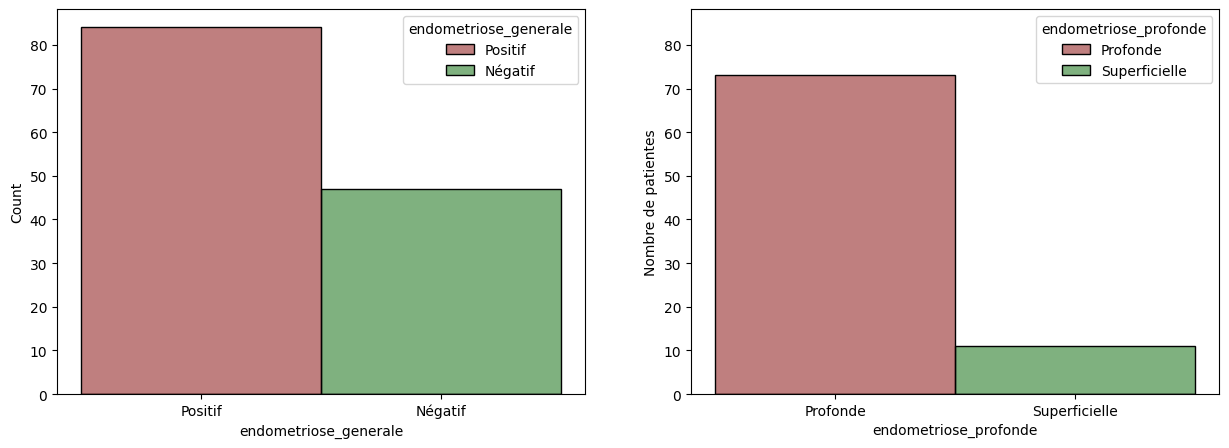

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes = axes.flatten()
custom_palette = {'Positif': "maroon", 'Négatif': "darkgreen"}
sns.histplot(data=df_with_target.replace({0: "Négatif", 1: "Positif"}), x='endometriose_generale', hue='endometriose_generale', palette=custom_palette, ax=axes[0])
custom_palette = {'Profonde': "maroon", 'Superficielle': "darkgreen"}
sns.histplot(data=df_with_target_endometriosis_patients.replace({0: "Superficielle", 1: "Profonde"}), x='endometriose_profonde', hue='endometriose_profonde', palette=custom_palette, ax=axes[1])
axes[1].set_ylim(axes[0].get_ylim())
plt.ylabel('Nombre de patientes')

## ML

In [28]:
df_with_target_endometriose_generale = df_with_target.copy()
df_with_target_endometriose_generale.set_index('Anonymisation', inplace=True)
df_with_target_endometriose_profonde = df_with_target_endometriosis_patients.copy()
df_with_target_endometriose_profonde.set_index('Anonymisation', inplace=True)
df_with_target_endometriose_superficielle = df_with_target.copy()
df_with_target_endometriose_superficielle['endometriose_superficielle'] = df_with_target_endometriose_superficielle['anapath.autre']

endometriose_generale = df_with_target_endometriose_generale['endometriose_generale']
endometriose_profonde = df_with_target_endometriose_profonde['endometriose_profonde']
endometriose_superficielle = df_with_target_endometriose_superficielle['endometriose_superficielle']
features_endometriose_generale = df_with_target.drop(['anapath.lusd', 'anapath.lusg', 'anapath.torus', 'anapath.autre', 'endometriose_generale'], axis=1).set_index('Anonymisation')
features_endometriose_profonde = df_with_target_endometriosis_patients.drop(['anapath.lusd', 'anapath.lusg', 'anapath.torus', 'anapath.autre', 'endometriose_generale', 'endometriose_profonde'], axis=1).set_index('Anonymisation')
features_endometriose_superficielle = df_with_target_endometriose_superficielle.drop(['anapath.lusd', 'anapath.lusg', 'anapath.torus', 'anapath.autre', 'endometriose_generale', 'endometriose_superficielle'], axis=1).set_index('Anonymisation')

In [29]:
## Init Metrics :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

### 1) Endometriosis in general vs. no endometriosis

In [30]:
# split
X_train, X_test, y_train, y_test = train_test_split(features_endometriose_generale, endometriose_generale, random_state=42, stratify=endometriose_generale)

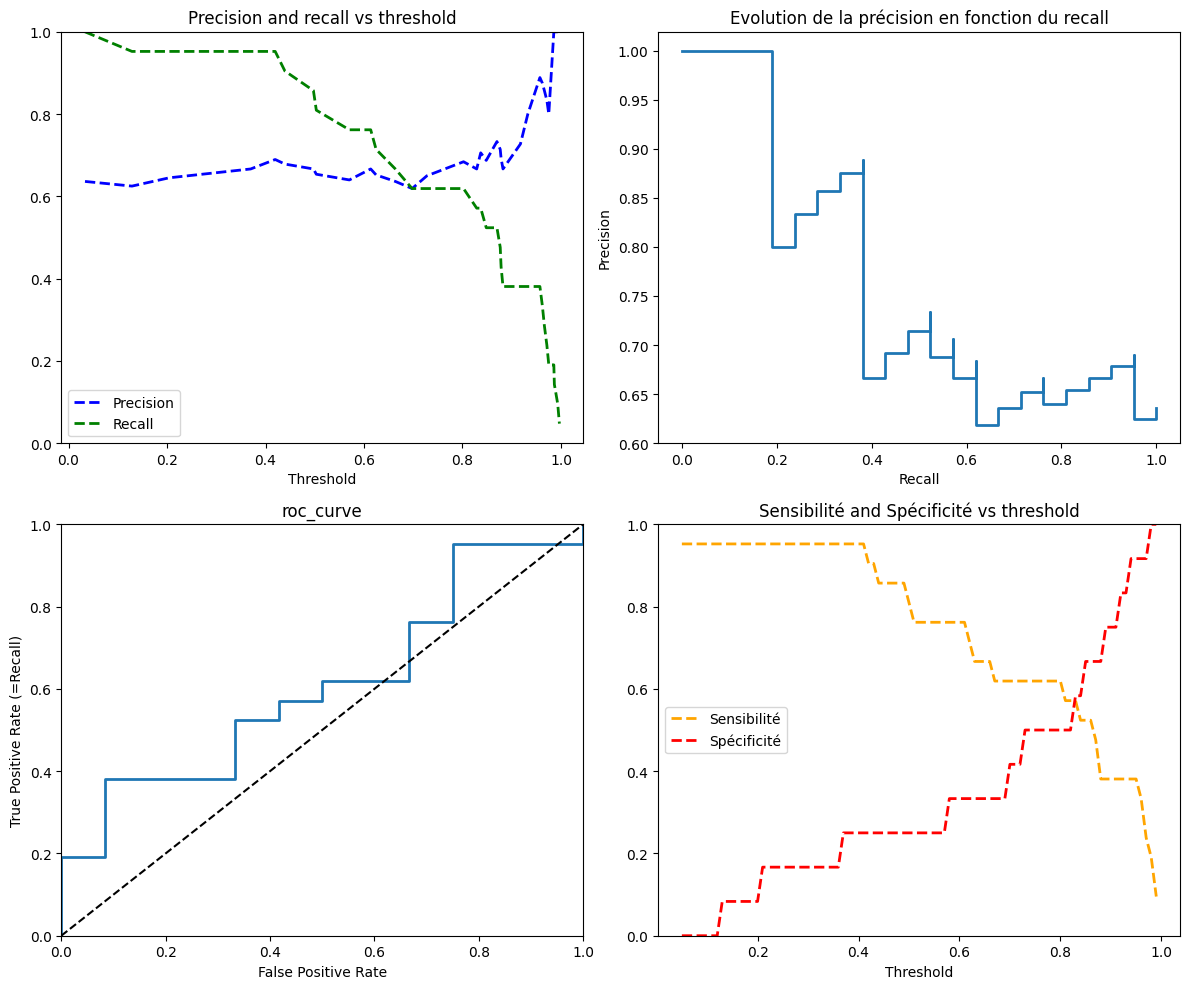

################ Priorité = gynéco ################
threshold = 0,5
Sensibilité :  0.8095238095238095
Spécificité :  0.25
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.38095238095238093
Spécificité : 0.9166666666666666


In [31]:
seed = 42
tree_BL = XGBClassifier(random_state=seed, )
tree_BL.fit(X_train, y_train)
pred_BL = tree_BL.predict(X_test)
model_to_plot(tree_BL, X_test, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
if data_select == 'original':
    print(f'################ Données receuil origine ################')
else:
    print(f'################ Priorité = {data_select} ################')
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

                                               feature  importance
51                                                imc        42.0
50                                                age        31.0
33                                           spotting        15.0
22                                          echo.lusg        14.0
2                                      atcd.chir.endo        14.0
25                                           irm.lusg        13.0
24                                            irm.adm        11.0
47                lésion rectum à la rectosonographie        11.0
49                                traitement_hormonal        11.0
12                                    sf.dig.diarrhee        11.0
52                                                  g        11.0
43                 lésion LUS D à la rectosonographie         9.0
31                               douleurs_defecations         9.0
38                                            nausées         9.0
1        

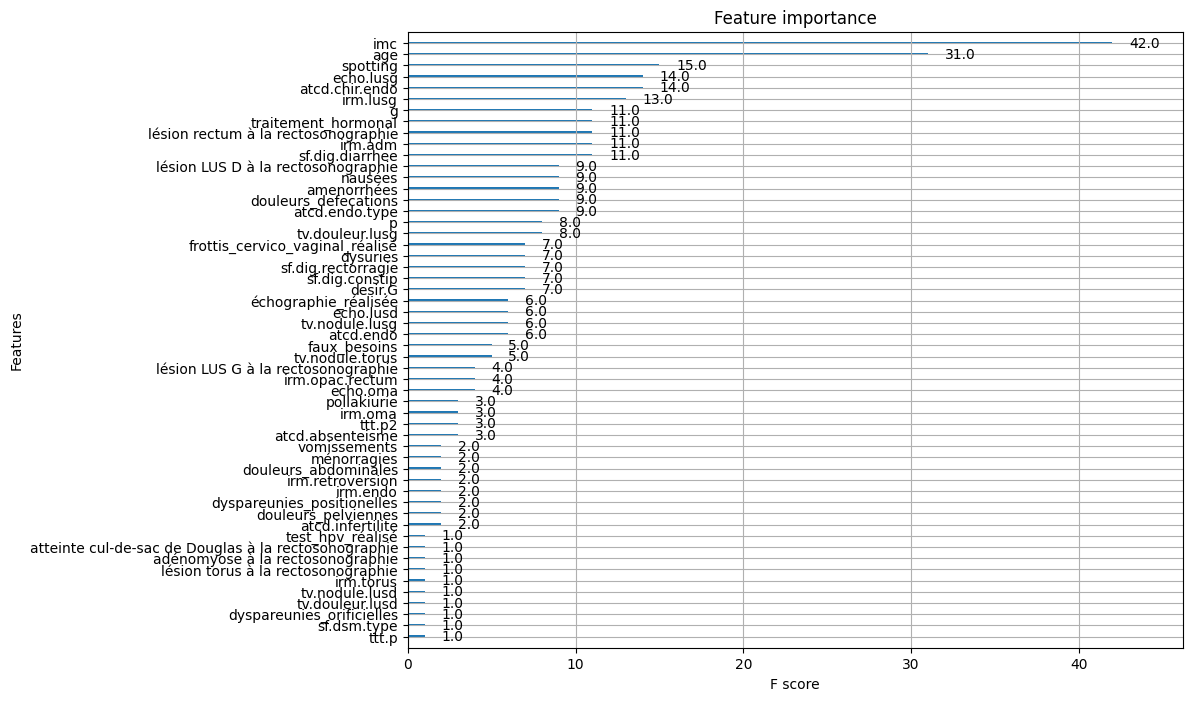

In [32]:
# Show feature importance
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

ax = plot_importance(tree_BL, )
ax.figure.set_size_inches(10,8)

### 2) Profound or superficial endometriosis

In [33]:
# split
X_train, X_test, y_train, y_test = train_test_split(features_endometriose_profonde, endometriose_profonde, random_state=42, stratify=endometriose_profonde)

In [34]:
len(pred_BL)

33

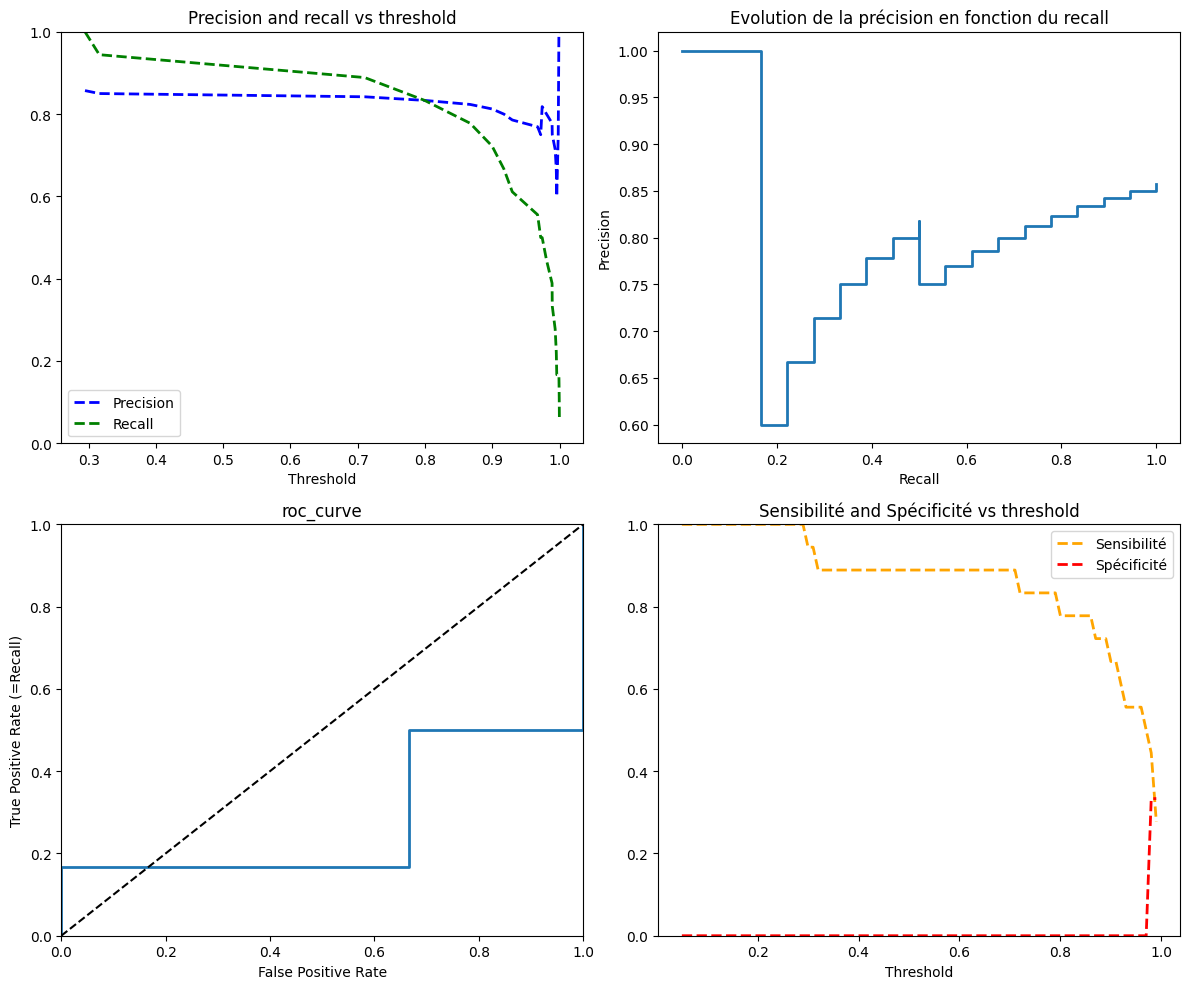

################ Priorité = gynéco ################
threshold = 0,5
Sensibilité :  0.8888888888888888
Spécificité :  0.0
Tri impossible, possiblement aucune valeur supérieur au seuil
_________________________________________________________
Best threshold : None
Sensibilité : 0.0
Spécificité : 1.0


In [35]:
seed = 42
tree_BL = XGBClassifier(random_state=seed, )
tree_BL.fit(X_train, y_train)
pred_BL = tree_BL.predict(X_test)
model_to_plot(tree_BL, X_test, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
if data_select == 'original':
    print(f'################ Données receuil origine ################')
else:
    print(f'################ Priorité = {data_select} ################')
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

                                 feature  importance
25                                  age        18.0
21                 échographie_réalisée        17.0
24                  traitement_hormonal        15.0
8                    sf.dig.rectorragie        13.0
26                                  imc         9.0
9                       tv.douleur.lusd         8.0
16                             dysuries         8.0
18                          amenorrhées         7.0
19                         faux_besoins         7.0
27                                    g         6.0
7                        sf.dig.constip         4.0
14                       irm.adherences         4.0
3                      atcd.infertilite         3.0
15                 douleurs_defecations         3.0
23  lésion rectum à la rectosonographie         3.0
2                        atcd.chir.endo         2.0
1                        atcd.endo.type         2.0
4                               desir.G         2.0
0          

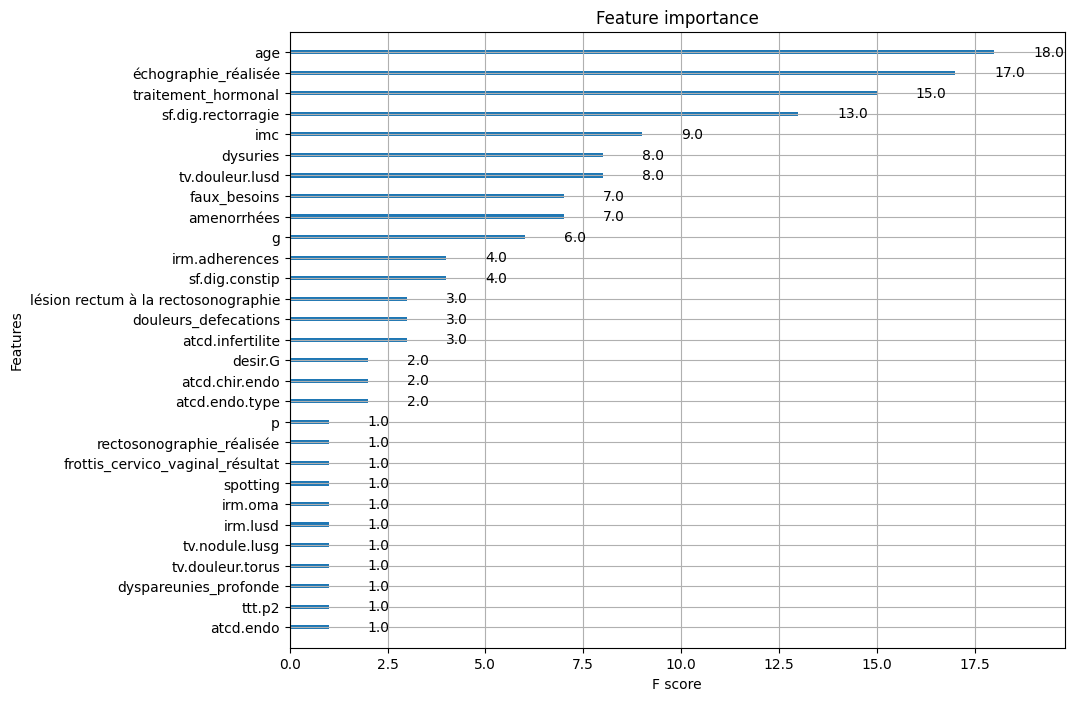

In [36]:
# Show feature importance
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

ax = plot_importance(tree_BL, )
ax.figure.set_size_inches(10,8)

### Superficial endometriosis (including patients with superficial & profound) vs. no endometriosis

In [37]:
# split
X_train, X_test, y_train, y_test = train_test_split(features_endometriose_superficielle, endometriose_superficielle, random_state=42, stratify=endometriose_superficielle)

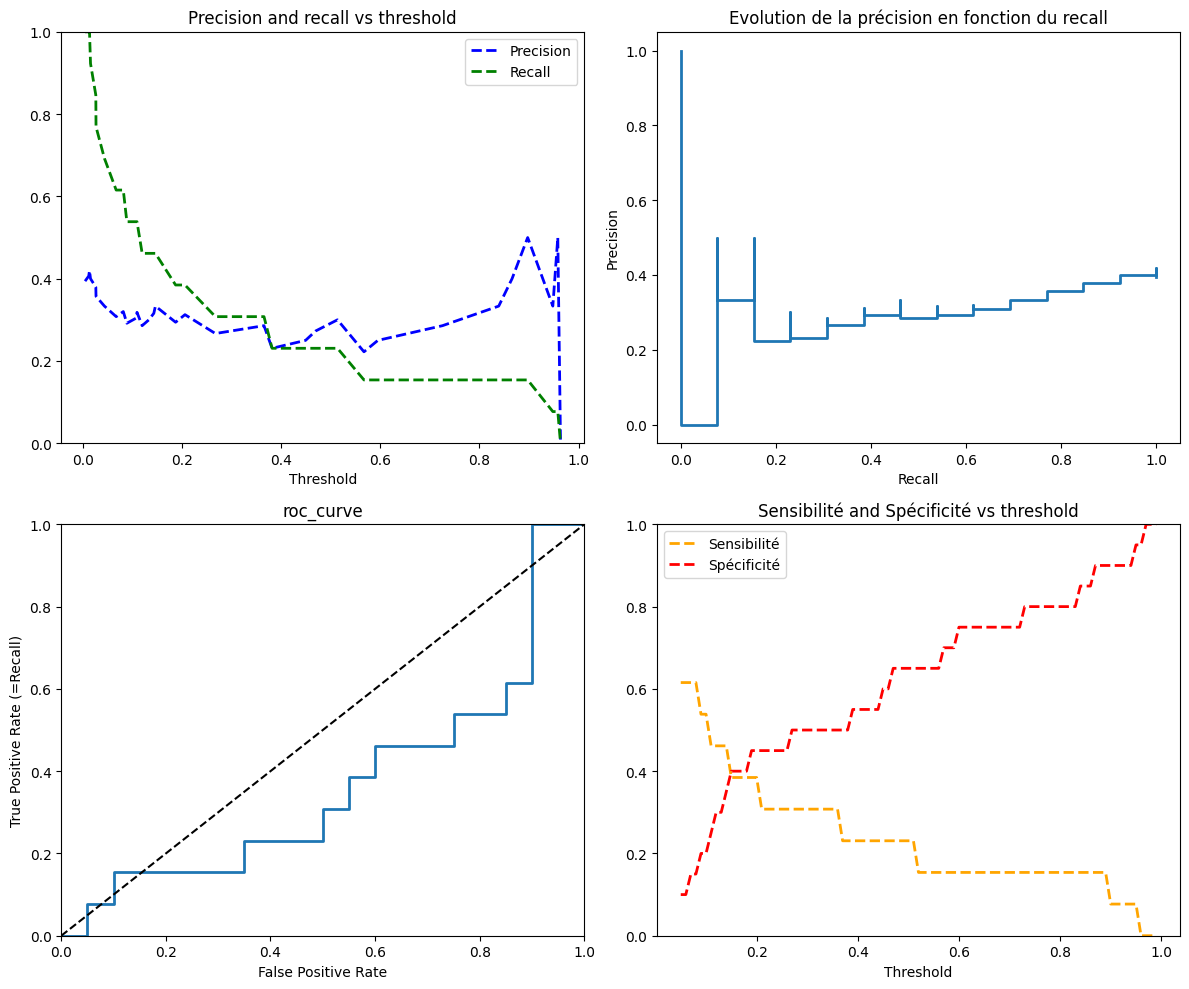

################ Priorité = gynéco ################
threshold = 0,5
Sensibilité :  0.23076923076923078
Spécificité :  0.65
_________________________________________________________
Best threshold : 0.87
Sensibilité : 0.15384615384615385
Spécificité : 0.9


In [38]:
seed = 42
tree_BL = XGBClassifier(random_state=seed, )
tree_BL.fit(X_train, y_train)
pred_BL = tree_BL.predict(X_test)
model_to_plot(tree_BL, X_test, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
if data_select == 'original':
    print(f'################ Données receuil origine ################')
else:
    print(f'################ Priorité = {data_select} ################')
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])